In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import itertools
import numpy.ma as ma

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [17]:
VERA_data_dir = '/home/ck/DIR/cornkle/data/vera_test/vera_run_data/'


lon_uv = VERA_data_dir+'VERA_4km/longitude_uv.nc'
lat_uv = VERA_data_dir+'VERA_4km/latitude_uv.nc'
lon_t = VERA_data_dir+'VERA_4km/longitude_t.nc'
lat_t = VERA_data_dir+'VERA_4km/latitude_t.nc'
flux = VERA_data_dir+'VERA_lhsh/'
wind = VERA_data_dir+'VERA_uv/'

In [18]:
lh = xr.open_mfdataset(flux+'*LH*.nc')

In [19]:
lh

<xarray.Dataset>
Dimensions:           (lat: 701, lon: 1128, time: 336)
Coordinates:
  * lon               (lon) float32 340.0 340.036 340.072 ... 380.536 380.572
  * lat               (lat) float32 -9.0 -8.964 -8.928 ... 16.128 16.164 16.2
  * time              (time) datetime64[ns] 2014-04-05T01:00:00 ... 2014-04-07
Data variables:
    STASH_m01s03i234  (time, lat, lon) float32 dask.array<shape=(336, 701, 1128), chunksize=(24, 701, 1128)>

In [20]:
lon_t_da = xr.open_dataarray(lon_t)
lat_t_da = xr.open_dataarray(lat_t)

In [68]:
lh_mean = lh.mean('time')

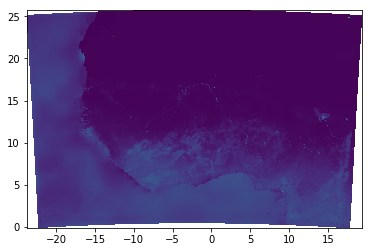

In [69]:
plt.pcolormesh(lon_t_da, lat_t_da, lh_mean['STASH_m01s03i234'])

In [70]:
#### select point or small box, not great for plotting:
sel_box = (lon_t_da>-5) & (lon_t_da<0) & (lat_t_da>4.5) & (lat_t_da<5.5)
lh_box = lh_mean.where(sel_box)

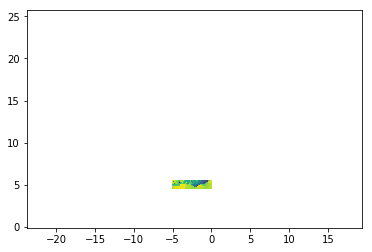

In [71]:
#### The domain is filled with NaN except for the selected area. You can use that for averaging etc 
plt.pcolormesh(lon_t_da, lat_t_da, lh_box['STASH_m01s03i234'])

In [72]:
lh_box

<xarray.Dataset>
Dimensions:           (lat: 701, lon: 1128)
Coordinates:
  * lon               (lon) float32 340.0 340.036 340.072 ... 380.536 380.572
  * lat               (lat) float32 -9.0 -8.964 -8.928 ... 16.128 16.164 16.2
Data variables:
    STASH_m01s03i234  (lat, lon) float32 dask.array<shape=(701, 1128), chunksize=(701, 1128)>

In [73]:
## To get rid of those NaNs:
lh_box_drop = lh_mean['STASH_m01s03i234'].where(sel_box, drop=True)
lat_box_drop = lat_t_da.where(sel_box, drop=True)
lon_box_drop = lon_t_da.where(sel_box, drop=True)

In [74]:
xlim = np.linspace(np.nanmin(lon_box_drop), np.nanmax(lon_box_drop), lh_box_drop.shape[1])
ylim = np.linspace(np.nanmin(lat_box_drop), np.nanmax(lat_box_drop), lh_box_drop.shape[0])

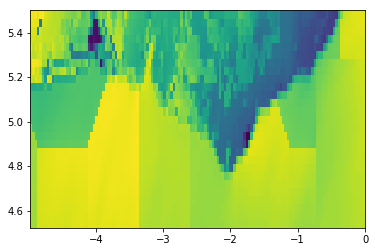

In [75]:
plt.pcolormesh(xlim,ylim,lh_box_drop)